In [1]:
# from tensorflow import keras
# from tensorflow.keras import applications
# # from keras.backend.tensorflow_backend import set_session
# import tensorflow as tf
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# config.log_device_placement = True  # to log device placement (on which device the operation ran)
# sess = tf.compat.v1.Session(config=config)
# # set_session(sess)  # set this TensorFlow session as the default session for Keras

# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Model 
# from tensorflow.keras import optimizers
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping

In [2]:
from facenet_pytorch import MTCNN
from PIL import Image
import matplotlib.pyplot as plt
import torch
from imutils.video import FileVideoStream
from custom_utils import return_all_video_paths
import cv2
import time
import glob
import os
import json
import random
import numpy as np
import imutils
import threading
from IPython.display import display
from os.path import join
from tqdm.notebook import tqdm
import traceback

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
from __future__ import print_function, division

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import copy

## Prepare data

In [4]:
class FastMTCNN(object):
    """Fast MTCNN implementation."""
    
    def __init__(self, resize=1, *args, **kwargs):
        """Constructor for FastMTCNN class.
        
        Arguments:
            stride (int): The detection stride. Faces will be detected every `stride` frames
                and remembered for `stride-1` frames.
        
        Keyword arguments:
            resize (float): Fractional frame scaling. [default: {1}]
            *args: Arguments to pass to the MTCNN constructor. See help(MTCNN).
            **kwargs: Keyword arguments to pass to the MTCNN constructor. See help(MTCNN).
        """
        self.resize = resize
        self.mtcnn = MTCNN(*args, **kwargs)
        
    def __call__(self, frames, double_frames=False):
        """Detect faces in frames using strided MTCNN."""
        frames_original = frames.copy()
        if self.resize != 1:
            frames = [f.resize([int(d * self.resize) for d in f.size]) for f in frames]
                      
        boxes, probs = self.mtcnn.detect(frames)
        
#         print(boxes)
#         print(probs)
#         return (boxes, probs)
        
        faces = []
        faces_lag = []
        frame_boxes = None
        idx = 0
        original_length = int(len(frames_original)/2) if double_frames else len(frames_original) 
        for i in range(original_length):
            frame_boxes = boxes[i]
            if frame_boxes is None:
                pass
            elif len(frame_boxes) > 1:
                return []
            else:
                frame = frames_original[idx]
                for box in frame_boxes:
                    faces.append(np.array(frame.crop(box/self.resize)))
                    if double_frames:
                        frame = frames_original[idx+1]
                        faces_lag.append(np.array(frame.crop(box/self.resize)))
                if double_frames:
                    idx = idx + 1
                idx = idx + 1
        faces.extend(faces_lag)
        
        return faces

In [5]:
def return_all_video_paths_v2(train_path = '../deepfake_train_full'):
    train_folders = [os.path.join(train_path, x) for x in os.listdir(train_path) if x[-1] != 'p']
    train_video_folders = [os.path.join(x, os.listdir(x)[0]) for x in train_folders]

    all_videos = {}
    for train_video_folder in train_video_folders:
        with open(join(train_video_folder, 'metadata.json')) as json_file:
            metadata = json.load(json_file)
        all_videos[train_video_folder] = []
        for key in metadata:
            ann = metadata[key]
            if ann['label'] == 'FAKE':
                all_videos[train_video_folder].append({
                    'FAKE': join(train_video_folder, key),
                    'REAL': join(train_video_folder, ann['original'])}
                )

    return all_videos

In [6]:
class GetFaces:
    
    def __init__(self, fast_mtcnn):
        self.fast_mtcnn = fast_mtcnn
        
    @staticmethod
    def open_video(path):
        v_cap = FileVideoStream(path).start()
        v_len = int(v_cap.stream.get(cv2.CAP_PROP_FRAME_COUNT))
        
        return (v_cap, v_len)
    
    @staticmethod
    def get_frames_from_video(v_cap, v_len, double_frames=False, nr_of_frames=48, offset=5):
        frames = []
        for j in range(v_len):
            frame = v_cap.read()
            if frame is not None:
                if j%offset == 0 or (((j+int(offset/2))%offset == 0) and double_frames):
                    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    frame = Image.fromarray(frame)
                    frames.append(frame)
            else:
                break
            if len(frames) >= nr_of_frames:
                if double_frames and len(frames) >= nr_of_frames*2:
                    break
                elif not double_frames:
                    break
                
        return frames
    
    def detect_faces(self, frames, double_frames=False):
        return self.fast_mtcnn(frames, double_frames)
    
    def resize_faces(self, faces, augment):
        args = {}
        new_shape = (224,224)
        resized_faces = []
        for face in faces:
            img = face
            if np.argmax(img.shape[:2]) == 0:
                args['height'] = new_shape[0]
            else:
                args['width'] = new_shape[1]
            try:
                resized_img = imutils.resize(img, **args)
                if augment:
                    resized_img = self.augment_img(resized_img)
                
                if np.argmax(img.shape[:2]) == 0:
                    diff = new_shape[1] - resized_img.shape[1]
                    resized_img = np.pad(resized_img, ((0,0), (0,diff), (0,0)), 'constant', constant_values=0)
                else:
                    diff = new_shape[0] - resized_img.shape[0]
                    resized_img = np.pad(resized_img, ((0,diff), (0,0), (0,0)), 'constant', constant_values=0)
                resized_faces.append(resized_img)
    
            except Exception as e:
                print(e)
                
        return resized_faces
    
    def create_batch(self, resized_fake_faces, resized_real_faces, \
                     batch_size, video_annotation):
#         batch_fake = []
#         batch_real = []
        batch = []
#         for i in range(m*2):
        for i in range(batch_size):
            s = int((batch_size/2)*i)
            e = int((batch_size/2)*(i+1))
            if s >= len(resized_real_faces) or s >= len(resized_fake_faces):
                break
            real = resized_real_faces[s:e]
            fake = resized_fake_faces[s:e]
            if len(real) > 0 and len(fake) > 0:
                X = np.array(fake + real) / 255
                Y = np.concatenate((np.ones(len(resized_fake_faces[s:e])), np.zeros(len(resized_real_faces[s:e]))))
                if len(X) > 0 and len(Y) > 0:
#                     if augment:
#                         temp = []
#                         for x in X:
#                             temp.append(self.augment_img(x))
#                         X = np.array(temp)
                    X = X.reshape((X.shape[0],3,224,224))
                    Y = np.expand_dims(np.array(Y), axis=1)
                    batch.append((X, Y))
                else:
                    continue
    #                 print('---')
    #                 print('0 faces from:', video_annotation)
                
        return batch
    
    def augment_img(self, img):
        if random.random() > 0.5:
            img = np.flip(img, axis=1)
            
        return img
    
    def process_functions(self, video_key, nr_of_frames=48, frame_offset=5, double_frames=False):
        video, video_len = self.open_video(video_key)
        frames = self.get_frames_from_video(video, video_len, nr_of_frames=nr_of_frames, \
                                            offset=frame_offset, double_frames=double_frames)
        faces = self.detect_faces(frames, double_frames)
        resized_faces = self.resize_faces(faces, augment=False)
        
        return resized_faces
    
    def get_resized_faces(self, video_annotation, double_frames=False, batch_size=16, nr_of_frames=48):
        start = time.time()
        
        resized_fake_faces = self.process_functions(video_annotation['FAKE'], nr_of_frames, double_frames=double_frames)
        resized_real_faces = self.process_functions(video_annotation['REAL'], nr_of_frames, double_frames=double_frames)
        
        batches = self.create_batch(resized_fake_faces, resized_real_faces, \
                     batch_size, video_annotation)
    
        return batches
    
    def insert_data_to_list(self, shared_list, all_videos_annotations, batch_size=16, max_len_shared_list=100):
        keys = all_videos_annotations.keys()
        while True:
            ones = np.ones(batch_size)
            zeros = np.zeros(batch_size)
            
            # Random folder and video each iteration
            key = random.choice(list(keys))
            video_annotation = random.choice(all_videos_annotations[key])
            
#             for key in self.all_videos_annotations:
#                 for video_annotation in self.all_videos_annotations[key]:
#             print(video_annotation)
            try:
                batches = self.get_resized_faces(video_annotation, double_frames=True)
                for X, Y in batches:
                    shared_list.append((X, Y))
                random.shuffle(shared_list)
            except Exception as e:
#                         continue
                print('-----')
                print(e)
                print(traceback.format_exc())
                print(video_annotation)
            # Check if list already full
            while len(shared_list) > max_len_shared_list:
                time.sleep(0.01)

In [7]:
all_videos_annotations = return_all_video_paths_v2()

In [8]:
fast_mtcnn = FastMTCNN(
    resize=0.25,
    margin=14,
    factor=0.6,
    keep_all=True,
    device=device,
    thresholds=[0.95,0.95,0.95]
)

# fast_mtcnn = FastMTCNN(
#     resize=0.25,
#     margin=0,
#     select_largest=False,
# #     factor=0.6,
# #     keep_all=False,
#     device=device
# )

In [9]:
get_faces = GetFaces(fast_mtcnn)

In [11]:
train_list = []
get_faces = GetFaces(fast_mtcnn)
val_split = int(len(all_videos_annotations)*0.9)
train_all_videos_annotations = {key: all_videos_annotations[key] for key in list(all_videos_annotations.keys())[:val_split]}
val_all_videos_annotations = {key: all_videos_annotations[key] for key in list(all_videos_annotations.keys())[val_split:]}
p_train = threading.Thread(target=get_faces.insert_data_to_list, \
            args=(train_list, train_all_videos_annotations,))
p_train.start()


In [1]:
train_list

NameError: name 'train_list' is not defined

In [13]:
len(train_list)

0

In [14]:
def generator(shared_list):
    while True:
        if len(shared_list) > 50:
            yield shared_list.pop(0)
        else:
            time.sleep(0.01)

In [15]:
gen_train = generator(train_list)

In [16]:
i = 0
for x, y in gen_train:
    break

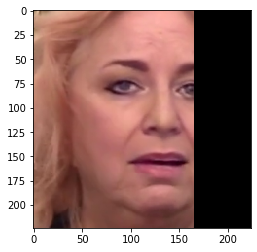

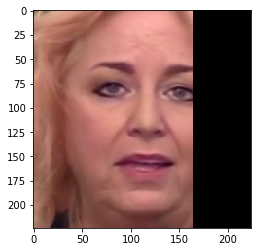

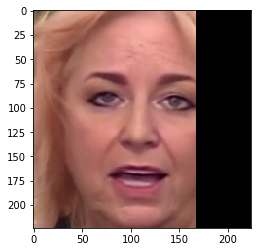

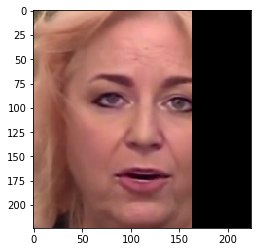

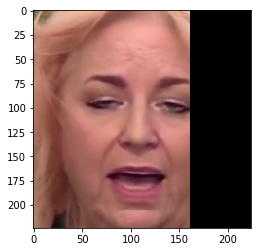

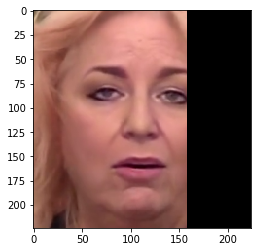

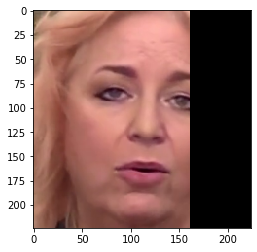

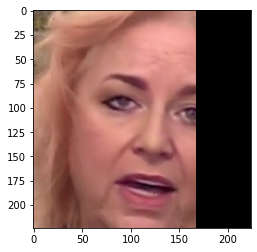

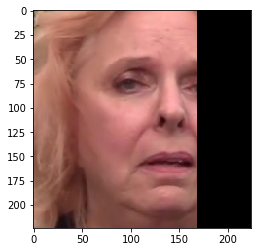

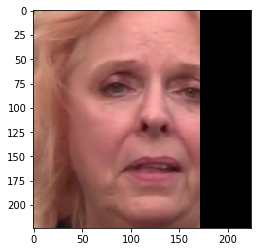

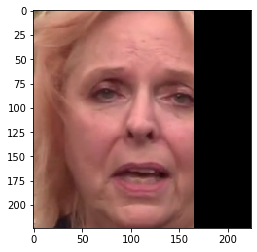

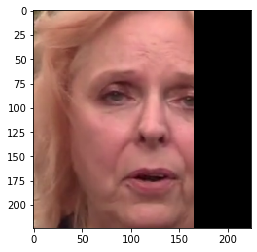

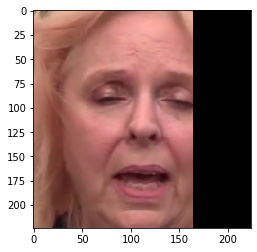

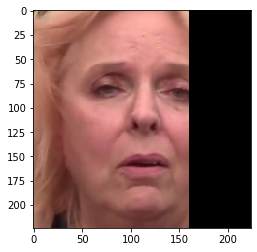

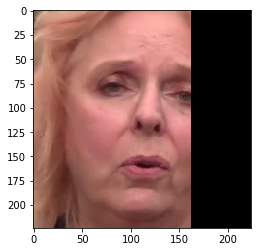

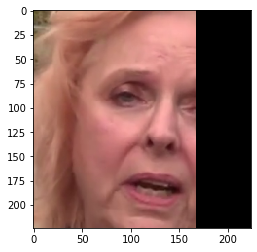

In [17]:
for img in x:
    plt.imshow(img.reshape((224,224,3)))
    plt.show()

In [18]:
frame = x[3].reshape((224,224,3))

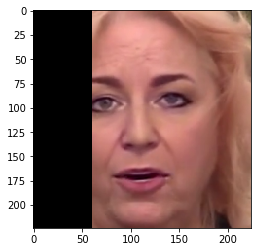

In [19]:
img = np.flip([frame], axis=2)
plt.imshow(img[0])

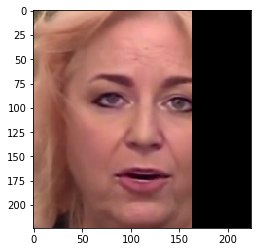

In [20]:
plt.imshow(frame)

## Train model

In [21]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
# model_ft.fc = nn.Sigmoid()
# model_ft.add_module('last_sigmoid', nn.Sigmoid())
model_ft.fc = nn.Sequential(nn.Linear(num_ftrs, 1), nn.Sigmoid())
# model_ft = nn.Sequential(model_ft, nn.Sigmoid())

model_ft = model_ft.to(device)

criterion = nn.BCEWithLogitsLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0002, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1) 
lr_sch = lr_scheduler.ReduceLROnPlateau(optimizer_ft, factor=0.3, patience=5)

In [22]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
def train_model(model, criterion, optimizer, scheduler, generator, 
                num_epochs=25, steps_per_epoch=500):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 9999

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        step = 0
        for inputs, labels in generator:
            inputs = torch.from_numpy(inputs).float().to(device)
            labels = torch.from_numpy(labels).float().to(device)

            step = step + 1
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
#                 loss = criterion(outputs) - labels

                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            print("Step: {} - Loss {}".format(step, running_loss / step), end="\r")
#             print(running_loss / step)
            running_corrects += torch.sum(preds == labels.data)
            if step > steps_per_epoch:
                break
        scheduler.step(running_loss)

        epoch_loss = running_loss / steps_per_epoch
        epoch_acc = running_corrects / steps_per_epoch

        print('Loss: {:.4f} Acc: {:.4f}'.format(
            epoch_loss, epoch_acc))

        # deep copy the model
        if epoch_loss < best_loss:
#             model.save_state_dict('mytraining.pt')
            torch.save(model, 'mytraining_full_3.pth')
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [24]:
model_ft = train_model(model_ft, criterion, optimizer_ft, lr_sch,
                       gen_train,
                       num_epochs=200,
                       steps_per_epoch=2000)

Epoch 0/199
----------
Loss: 11.0376 Acc: 127.0000818187983

Epoch 1/199
----------
Loss: 10.8117 Acc: 126.0000728077566

Epoch 2/199
----------
Loss: 10.2032 Acc: 126.0000433209936

Epoch 3/199
----------
Loss: 10.2326 Acc: 127.0000689252206

Epoch 4/199
----------
Loss: 10.1070 Acc: 126.0000104633086

Epoch 5/199
----------
Loss: 9.8105 Acc: 127.0000721155395

Epoch 6/199
----------
Loss: 9.8872 Acc: 126.00007958099124

Epoch 7/199
----------
Loss: 9.8128 Acc: 126.0000866959626

Epoch 8/199
----------
Loss: 9.6224 Acc: 126.0000540430144

Epoch 9/199
----------
Loss: 9.6509 Acc: 126.0000649542133

Epoch 10/199
----------
Loss: 9.7294 Acc: 126.0000627486267

Epoch 11/199
----------
Loss: 9.6401 Acc: 127.0000983943963

Epoch 12/199
----------
Loss: 9.6659 Acc: 126.0000407963574

Epoch 13/199
----------
----- 836 - Loss 9.338876704707677
need at least one array to stack
Traceback (most recent call last):
  File "<ipython-input-7-e0d5b37deb14>", line 136, in insert_data_to_list
    batche

RuntimeError: CUDA error: unknown error

In [23]:
model_ft = torch.load('mytraining_full_2.pth')
model_ft2 = train_model(model_ft, criterion, optimizer_ft, lr_sch,
                       gen_train,
                       num_epochs=200,
                       steps_per_epoch=2000)

Epoch 0/199
----------
Loss: 9.6770 Acc: 127.0000343595277

Epoch 1/199
----------
Loss: 9.7428 Acc: 126.0000755617904

Epoch 2/199
----------
Loss: 9.9018 Acc: 126.0000246129376

Epoch 3/199
----------
Loss: 9.8084 Acc: 127.0000616726974

Epoch 4/199
----------
Loss: 9.9175 Acc: 127.0000045777875

Epoch 5/199
----------
Loss: 9.7198 Acc: 126.0000140479506

Epoch 6/199
----------
----- 1052 - Loss 9.844530181853036
need at least one array to stack
Traceback (most recent call last):
  File "<ipython-input-6-c9b2f71155d1>", line 136, in insert_data_to_list
    batches = self.get_resized_faces(video_annotation, double_frames=True)
  File "<ipython-input-6-c9b2f71155d1>", line 114, in get_resized_faces
    resized_fake_faces = self.process_functions(video_annotation['FAKE'], nr_of_frames, double_frames=double_frames)
  File "<ipython-input-6-c9b2f71155d1>", line 106, in process_functions
    faces = self.detect_faces(frames, double_frames)
  File "<ipython-input-6-c9b2f71155d1>", line 34, 

KeyboardInterrupt: 

In [23]:
model_ft = torch.load('mytraining_full_2.pth')
model_ft2 = train_model(model_ft, criterion, optimizer_ft, lr_sch,
                       gen_train,
                       num_epochs=200,
                       steps_per_epoch=2000)

Epoch 0/199
----------
Loss: 9.6559 Acc: 126.0000327526551

Epoch 1/199
----------
Loss: 9.7508 Acc: 127.0000320994147

Epoch 2/199
----------
Loss: 9.6673 Acc: 126.0000108060417

Epoch 3/199
----------
Loss: 9.7608 Acc: 126.0000061871283

Epoch 4/199
----------
Loss: 9.7372 Acc: 126.0000163245012

Epoch 5/199
----------
Loss: 9.7060 Acc: 127.0000143164387

Epoch 6/199
----------
Loss: 9.8739 Acc: 126.0000670197437

Epoch 7/199
----------
Loss: 10.0110 Acc: 127.0000856854983

Epoch 8/199
----------
Loss: 9.6635 Acc: 126.0000943465534

Epoch 9/199
----------
----- 1111 - Loss 9.656533383014072
list index out of range
Traceback (most recent call last):
  File "<ipython-input-6-c9b2f71155d1>", line 139, in insert_data_to_list
    random.shuffle(shared_list)
  File "C:\Users\Anti\Anaconda3\envs\torch\lib\random.py", line 277, in shuffle
    x[i], x[j] = x[j], x[i]
IndexError: list index out of range

{'FAKE': '../deepfake_train_full\\dfdc_train_part_13\\dfdc_train_part_13\\sherosbvvz.mp4',

KeyboardInterrupt: 

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, lr_sch,
                       gen_train,
                       num_epochs=200,
                       steps_per_epoch=2000)

Epoch 0/199
----------
Loss: 10.5068 Acc: 127.0000904371126

Epoch 1/199
----------
Loss: 10.0317 Acc: 127.0000906314531

Epoch 2/199
----------
----- 1832 - Loss 9.774019267849265
need at least one array to stack
Traceback (most recent call last):
  File "<ipython-input-6-c9b2f71155d1>", line 136, in insert_data_to_list
    batches = self.get_resized_faces(video_annotation, double_frames=True)
  File "<ipython-input-6-c9b2f71155d1>", line 114, in get_resized_faces
    resized_fake_faces = self.process_functions(video_annotation['FAKE'], nr_of_frames, double_frames=double_frames)
  File "<ipython-input-6-c9b2f71155d1>", line 106, in process_functions
    faces = self.detect_faces(frames, double_frames)
  File "<ipython-input-6-c9b2f71155d1>", line 34, in detect_faces
    return self.fast_mtcnn(frames, double_frames)
  File "<ipython-input-4-140578ad711d>", line 25, in __call__
    boxes, probs = self.mtcnn.detect(frames)
  File "C:\Users\Anti\Anaconda3\envs\torch\lib\site-packages\face

In [ ]:
i = 0
for x, y in gen_train:
    if i > 4:
        break
    i = i + 1
    idx = 0
    print(y[idx])
    plt.imshow(x[idx].reshape((224,224,3)))
    plt.show()
    
    idx = 9
    print(y[idx])
    plt.imshow(x[idx].reshape((224,224,3)))
    plt.show()

In [ ]:
idx = 1
print(y[idx])
plt.imshow(x[idx].reshape((224,224,3)))

## Predict results

In [10]:
model = torch.load('mytraining_full_3.pth')
model = model.to(device)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
val_split = int(len(all_videos_annotations)*0.9)
val_all_videos_annotations = {key: all_videos_annotations[key] for key in list(all_videos_annotations.keys())[val_split:]}

In [12]:
val_all_videos_annotations.keys()

dict_keys(['../deepfake_train_full\\dfdc_train_part_45\\dfdc_train_part_45', '../deepfake_train_full\\dfdc_train_part_46\\dfdc_train_part_46', '../deepfake_train_full\\dfdc_train_part_47\\dfdc_train_part_47', '../deepfake_train_full\\dfdc_train_part_48\\dfdc_train_part_48', '../deepfake_train_full\\dfdc_train_part_49\\dfdc_train_part_49'])

In [13]:
all_videos_annotations['../deepfake_train_full\\dfdc_train_part_00\\dfdc_train_part_0'][0]

{'FAKE': '../deepfake_train_full\\dfdc_train_part_00\\dfdc_train_part_0\\owxbbpjpch.mp4',
 'REAL': '../deepfake_train_full\\dfdc_train_part_00\\dfdc_train_part_0\\wynotylpnm.mp4'}

In [14]:
def evaluate(path):
    resized_faces = get_faces.process_functions(path, \
                                        nr_of_frames=10,\
                                        frame_offset=20)
    X = np.array(resized_faces) / 255
    X = X.reshape((X.shape[0],3,224,224))
    
    if len(X) > 0:
        with torch.set_grad_enabled(True):
            inputs = torch.from_numpy(X).float().to(device)
            outputs = model(inputs)

        return outputs.cpu().detach().numpy()
    else:
        return []

In [15]:
res = []
cnt = 0
for key in val_all_videos_annotations.keys():
    for obj in val_all_videos_annotations[key]:
        try:
            path = obj['FAKE']
            print(path)
            outputs = evaluate(path)
            res.append({'path': path, 'annotation':'FAKE', 'predictions': outputs})
            path = obj['REAL']
            print(path)
            outputs = evaluate(path)
            res.append({'path': path, 'annotation':'REAL', 'predictions': outputs})
        except KeyboardInterrupt:
            raise KeyboardInterrupt
        except:
            pass
        cnt = cnt + 2
        print('cnt', cnt, end="\r")

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gthvvygfcj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lxeqbyddvt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\yunqitmhjo.mp4


KeyboardInterrupt: 

In [15]:
res = []
cnt = 0
for key in val_all_videos_annotations.keys():
    for obj in val_all_videos_annotations[key]:
        
        path = obj['FAKE']
        print(path)
        outputs = evaluate(path)
        res.append({'path': path, 'annotation':'FAKE', 'predictions': outputs})
        path = obj['REAL']
        print(path)
        outputs = evaluate(path)
        res.append({'path': path, 'annotation':'REAL', 'predictions': outputs})
        cnt = cnt + 2
        print('cnt', cnt, end="\r")

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gthvvygfcj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lxeqbyddvt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\yunqitmhjo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hbrgvmrtnn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mwizcjywkd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\stdavraahk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ymswdhnnyp.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gwzttezkpv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lsfsintfky.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xrtmepdfyh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bfkfrtmiub.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bpkpvrqduq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ryuocfdklj.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\iyaxgpepqr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mazmrfplfz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vmasbhlvba.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ihszkmcwvw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jvjstqodrq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ytowqhkwnk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bbhjnxbdco.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ccevbixrwu.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\sbypubftlo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\akddowubef.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\muuwtyrtxs.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bpkpvrqduq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\goolpwftkw.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cerwxjqsmv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\azaahiwadu.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cplkdbfpxj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lobucnofjd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wmavhagafr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\pxwsxsqrxo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\amdsocyvfq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xeyzkwymwu.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\peiyocyctt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\partcfzlbj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ugzonpnovr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zdlhavfmit.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wdafpwgevq.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jvmjjaljep.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\sytddqezij.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\anxeqgmacn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mazmrfplfz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\uerapqglmr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\byzhqvspaz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\npiptahdld.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bogcoldwxa.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hxrruqinnh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\tvffpggbrc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vrtymxriej.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zdnepyqjiy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\pvbdhnfemx.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\edpjgsunfy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\awsceniain.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\rupmycdwnn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\azaahiwadu.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\fvvzvoommr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\pxwsxsqrxo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gvcwrbcqdd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ccevbixrwu.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gnytcpethj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ihszkmcwvw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\tkcwbxfroj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jbcnsmlysc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ckpqmqcbms.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\neuptrhfdr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\awsceniain.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\djxogftlxw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qzdirjlxbw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ldloctgunu.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\azaahiwadu.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xqeuvgclvw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kffwdagndv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\eqkodjrjyz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kffwdagndv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ubasafrfsx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xrtmepdfyh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cjrzklaqjt.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ovsjtbttiq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jtwpwdqmxz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\nhnhwalplb.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\sjikbuyuri.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\uwfryvyjko.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jtkyoulizr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kaklqxzcgt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\icbzbcwlgf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wphztpbiqb.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zqrzqekofe.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\urdegesals.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bogcoldwxa.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\fzxsggojyo.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ixollenxsr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\txfozivwlq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\tvowfywxab.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\anjzzdyhno.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\dnrqehggwv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qivnumuetu.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hsjukoflzf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lpfmqnxogg.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\oejfypsbfh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wedyarmcvw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xyockehads.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kfhkmcvwvd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lvgxlibzrg.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hrizczebyb.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jjzpwcociv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ubtikiqoeg.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qaydrxmkyy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\sqrjoqavds.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bsjucwhlrj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bkcqlavtab.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qtlgvftgpt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wfxsepsnxb.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jjzpwcociv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cyxzkgsafw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\phfljuoghg.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kjnabqlvsj.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xxbdurtubx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bkbokyebco.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lzpqwdpkjm.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\iewggzdtmd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wnqrnnplrh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\rvcalvhoxm.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ldvtyirqec.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jihpgmechw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ixlpgpwyoa.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\guemdthavy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\fepzrvdwje.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\djlkkqmjkk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\pjwlrdjgbp.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\fwjhcmqmgk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\rayhrvqorn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cgetledlxm.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\myjhgnezbc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ctavqrrmgv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ptfpegxozl.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hncvqppfad.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vcrmlccwlo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qdtgqujwjj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\etrdptdued.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vguyewjvsd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\sjgkzwbfmz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jhdrxeelhb.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ionmsllaxk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bkbokyebco.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mhpfornvnc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lagaytbhyh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lknemxscab.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\encvnokybd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jpnvbfcekk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ibvyapyort.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qqpxqqwyzt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\udvjwmiwlr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\eujsvdhrdm.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\oavhkxwsrw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mjgaoewdpl.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\depwiwjaya.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ohnocvcnov.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\sivrgbsaog.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\yzkzawtzge.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ecsjyvknwr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ekxsduhvwh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xdxkbcyfgi.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gxxlbjuyza.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\iswoxfhubj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wedyarmcvw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\krfrzaghpv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kfhkmcvwvd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cyvjigpbao.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xzavftnhdl.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kypqqvwvvn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gyjdebcqrc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\svmgbkjvhz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mxsdxajbkn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ekxsduhvwh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zmkpjobtvj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\guemdthavy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\snkpjieurz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jjzpwcociv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wsyrpvtfne.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ptfpegxozl.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jcfisfexkt.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\azobkfldrm.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\djlkkqmjkk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gomqkftobw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hohrvrekpk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vmnqltuzmx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zmsfyoxdou.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ticpxguaeh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ftxavczbvi.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\klhrwllfsy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cbdquwkipe.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\debaivdfyo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gxxlbjuyza.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qtftvismyz.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qwgmdbnovi.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\uuwidltakm.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xqtyfrcnww.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bsjucwhlrj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hhpmuiybqn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\rayhrvqorn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\rxfqtredtd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\opsswckvib.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zxuomjbsrf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kzqqgctnoy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zvajhudwuo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qohtjkzity.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qonorwhmkk.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\npemjjupmd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\myjhgnezbc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xveensywhc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bsjucwhlrj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\aulykluogb.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\iverjmtcbg.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jiaixqijtv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\okgrsopppw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mlfbyfnulv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qohtjkzity.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cvqgrezhur.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bufrlvvuuu.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\fxiagzltmj.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jyuaxigvdi.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ynmluajwre.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hgefzguctw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ibvyapyort.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bfluunemxz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\iewggzdtmd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\yyehckvovh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ohnocvcnov.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\etqulfbomt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ekxsduhvwh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\rllevpaqrk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\yzkzawtzge.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\pdwwczhhla.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\usfwkpursg.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qacvhhqluv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\arcigchzav.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\sazcnznkjo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hnhrxcfqsy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wnlnuotcpw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zhikfuveaj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\egyemqrvna.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ebxrckrvig.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\pmhilgxldy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\dkuvktiywb.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\iobunwzuda.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ybhlejchyi.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\djkzdbcfgb.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lpymgpaiup.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ichbbqrzzf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hdsbvyxutk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cgshwqygpt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hfxwupsztp.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gdxtazndzk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bvbgrnnbsi.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\aefpqqxvbe.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xbiyhyjsji.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hrcfjojxqq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vwrrieyzck.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\rutpskylur.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hpneudadtf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\pkovaypwgw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jcdjulohcc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\shrpamtirw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gkijjgjxhl.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\eabucrvsij.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\akmteetttx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\dijbnarhjk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\tfdtzsmmok.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\iefyuoxhji.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\auhelqsolf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zqyzobyqak.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\urydhdejxz.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bcoydxioxf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\sazcnznkjo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zrpomfnrjt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\emxqsgqtdz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wbcnvdycxo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\puankmtkpx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\dihikfoowv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hfxwupsztp.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\tetcmnvwah.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kcbybymbna.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ndyfmioebl.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\shrpamtirw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\dgbqnwuqlf.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\yhjayveuuj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wyfbrbliyj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\daisdfsvkt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wyfbrbliyj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\acjwolqjgw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vwrrieyzck.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\uodiwnpryc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ykxfnneiuq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bxdyjejzht.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\smcyybtwrp.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zjxgldsnew.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mweyejimuy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bibpelmopy.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\dyesrdnfia.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\puankmtkpx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ijjnmqocav.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\otakcxftoa.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ehjkvtgdkm.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xuelsqpflp.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\djozjfcnwk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\oaptmwroki.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\pocjaqpnzv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bgbkogrfys.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ywyiwqiock.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ffevfcjxva.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gdvnljutuu.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\igwyftdshr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mdezaahvyt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\szivkpgcki.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ycttwzwkpx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\eibvvpheen.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lpymgpaiup.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\arskgfjbig.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xbiyhyjsji.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\iedayonitd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zqyzobyqak.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jttbenjinn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\egyemqrvna.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\dytpllwlko.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ggwxcsfecd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\sazcnznkjo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qumwfrunqq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vgeowvmdic.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xeawrxpvco.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\byldztfret.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\fdziwiuoer.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\byldztfret.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\louzhesvcx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\egyemqrvna.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kgkpukplcu.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ocjyxxfhfq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\pysjedccrf.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\simmveubsc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\defeqlyysh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\iipnhxfxmp.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qjtbhtgrar.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\srlxrlvpbk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\idnrnqaocs.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hyihnzrlex.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\oeqjhgzeai.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jftslzalsj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mwjnvghsbe.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\eedwazoljh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cwcwgibsgo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kelbhtsayy.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\pvwsgjbvmi.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qjtbhtgrar.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\aexkdsocpo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\poangahcby.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\rhwnodoydg.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\brvnvecdnm.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\tmfvbrktwj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\irriroabtu.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\djabgmttqg.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cctpcnsfka.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\nogfxrnhgf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\icjdgqaegf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kdbdrgkkve.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\oryxqexhku.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ykywskdwlc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vzftnuycbj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lgnxeyzclt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ivnnzevjef.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zytgvkxooc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\iwclmdjwvc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cwcwgibsgo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gleijkfzhr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\aevxvajusj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kyxqqazucy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\brvnvecdnm.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\upycebbxjj.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\tvfyjxvmsi.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ovkqlfuzsh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zyrrjszvrj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qsakhvaram.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gpzyphbuiq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vmksyqbkpl.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\oughejkndd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\fvwhpsrmwx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\godmopteom.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\juqgdaxcej.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\dudffwylgp.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\nqptouihyw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cyqsfqlbgp.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hmfskvugyq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bljpdykszf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\klncxcncuc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\yvixrplqty.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lsweehznwt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vmksyqbkpl.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xcikxizrej.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\imnyrjolno.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ymiwvlawuk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\tlzordotqw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\eugpvwbpiz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ksfuiztwuc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vxdeuyjhuq.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ikyetixxef.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\pvwmgrtott.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\aaeucwtkdx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\rslxpafeir.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\fudzlwacws.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\arwefyghir.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gjcvhdeciv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\oyafyvlxwx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\znhrqqxtwf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ooflqxghgs.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ypddjvcfwh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\imnyrjolno.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jksdgjxuws.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mrwerotrpw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wwzfxsvubn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\gilrccufxa.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lvvpfgszfq.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\dmoctfubep.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xoxzdogmfx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hvhrlowtzh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\yoyuttrzdw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\huvgomcylt.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xoxzdogmfx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\qxguvdlkql.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\tgnynnlgym.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\wsmvrhsxpd.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hqtjafdzow.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jyfnzyvznx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\thbpurlwnf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\onojshreyv.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ygocfjqlmk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kpstxygjaf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zjmhvazsku.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\ticjnwfzmb.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hzinugqapj.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zyfxvtxrsk.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zrshwhidyn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\scrogtfgmn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hcyqdktfiv.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mnbrtdchxx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vohwauspnx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vnnzwvvhjc.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cdeesuuuqz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\tdqmvqupgs.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\fmsxwtarwd.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\hnpjlqwpos.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\zdhrbexqxz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bgvuxeubtf.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\orfsriylyy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\xsljppzuip.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jmvmztomdw.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\yhnwiuxnox.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\bdeniywtnn.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\saalbotqyo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\cxcopmaqcx.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\jygbqsigcr.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\lyjqayxdyh.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\vwigtbeivy.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\rwthfzmntz.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\saalbotqyo.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\javxtwhvub.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kxarjtvlly.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\mbkgcmpihi.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\kxarjtvlly.mp4
../deepfake_train_full\dfdc_train_part_45\dfdc_train_part_45\favpbouums.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mxypluhkya.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\boyribbmyg.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pmywbdljmw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zigbepfygf.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ochecdqslx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fnqrydakgc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\cktsyobheu.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zzrmokkxka.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pvxiloudsj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hakfzgbjpc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kyeisbhtzf.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wrersztmaj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fatnoezenh.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qpidodqzhy.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mhrqokvzmx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dmhsizbghm.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dpegbdzijf.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\synptkekgs.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tmmjeiysan.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\btzqiokysa.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vqibhetnwa.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wjorrptner.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\knbodjyiew.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hcvdpnhqsa.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pdyrvsvwyi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fxqovlruio.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\eclpgjjies.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\drfxxsoqpu.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vwlelxjgey.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nsavbywhlu.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\psyxxwppgx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\laupbbdwmz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kzrbfsoxtj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\msbqgoxxlh.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\djrfxolqxm.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vcqdmzirff.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ijkwihnmld.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wbsjlgxstv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dmcnsuwsin.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rdqfwzpzlg.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kekscwpfqa.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\bpnexhvqmc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ijeqomctsa.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\buejhiahpy.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tmmjeiysan.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kpllrzoznl.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dogotzkdiw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\bwywgggeen.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wzbhnryjxb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kiggwcrxkb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lzmxqxrruv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\opqtgolofy.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wwnrsxxqjb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\upcpqraglb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pliqrpjnfd.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\uomfimsutw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\obrchniwrr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ifeiovrcyz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rjtxmfklwi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mhrqokvzmx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nvezjvkfbu.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vdvffooule.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\uoosazyhmf.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\sjqrdyzkgl.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hajkizpxpz.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pnooyxdnwq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\oxfbjycxvy.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\eqbhmqbwak.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\asownnwcfl.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vqdbxmolda.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lmunrhcpac.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ylhtymvmbn.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ulvnqoxiud.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\jiisquwdyu.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wzbhnryjxb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lmibdzouid.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\bpeemkcxad.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\caiunsnquf.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xumdemvmqz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mztlucosuc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ilxmktuups.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dwpoopdkmp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hyheeyffxt.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\drfxxsoqpu.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tkejctiioh.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\isxxybhuls.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ctjcicttwr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qupucojlwo.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tlsoagxovk.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ezrgemzvju.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pczknawtyv.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qgvfnphfqc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hakfzgbjpc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ixlzpzmnam.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mjwswqujru.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\iivpdtsjfc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dpegbdzijf.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fpmkrioqgi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ahdegpidyf.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mvofqyugsp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nujhgmhtmr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xwwnlzvgtj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hpcivouyku.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mrlijyislg.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fzmmpujffb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dkobxivwmn.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hguygahizr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gfdenskfme.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\thnywrwayf.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nujhgmhtmr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rakqwcmoxi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hpcivouyku.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\joezmuxfzt.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\sxzddbulvt.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\iwwvnksime.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fmaaowxqpw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\luuwykgpxq.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zwiesboten.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\oyjnnyiege.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\uepnpgrhzn.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tmmjeiysan.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tkqergsqqw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nujhgmhtmr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lkakdxttlz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pqmrrobvmc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rqwilveqiv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qjvwhzoaek.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vwxoisiedz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mcehvkoidm.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qfzlclsckz.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gqzgsjhuem.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pzsuborsgk.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xaxhcaevif.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gwqdrapybq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wxwfbbmzxb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\cwtgddlhby.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zejznzandc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qqrvyhjznq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ezmhgyjwqt.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\akhfhjgnnv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fgutlhwbua.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hdauuytvhx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vysvnufvyc.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qozxffebjc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ctdwtfcjei.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xwmyogjeaj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rwcwopfvax.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gxgseukasu.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\jiivsvouxw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\atqiwttwse.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\eqihscbsti.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\krsorcwelh.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wwgmzeavbd.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mqatynlckd.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\jiugbwylsj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\flvarrfpdw.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\jxaawrsxdd.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\jutkyeczir.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rkezgzxnoo.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dketpabwga.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\boiexvxboc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\furokqojrv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ziagvqaznp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qpmepdhqlv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mhrsezuwcd.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gwqdrapybq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pzercnfmug.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\cwtgddlhby.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xpqnexkjqw.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\epwspldhvx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\cwtgddlhby.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\adjeohbzmp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ragjclplkx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qgrlklhrhy.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pzsuborsgk.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fclbpdxgxz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\urxifmrcll.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ajxmoyqvmj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lijodtitxz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wgbmiiaomb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hdauuytvhx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zlpuvdtsrm.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fvgimbewza.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hixdloourp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\cqttsbnsag.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zbsjlcsetv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rjbrjxlatq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\miiymgajty.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hjledymcmc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xhonoegyad.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mhllqixqud.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zmplbhkwns.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\onjinaahul.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dketpabwga.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dlbxnfthal.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xsjvpvpaib.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kzkqxqpmqd.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\uxjrgfjgtx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fcvzlzfufb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\scxqsgpdpw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\phsausetmv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\egqugnqibo.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hpnhftyxnr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xjjavnfjje.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hpnhftyxnr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\yuoqanqjex.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dketpabwga.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tnxxvepdsr.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kqzchexoru.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\asewdghwiy.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rrygkjskib.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\asewdghwiy.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kpqqjbbugp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nxjrucsptp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dyocqhemds.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fcvzlzfufb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ivdoqanbyx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xhonoegyad.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xazdhdnwhh.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tpjydgkvdt.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lkoozjttqx.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xdyuvgvhvv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vdlchuptjz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ovgsjciwha.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qzlnazgsto.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\csrzijbfda.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\aypljgeqag.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\yhexvgfmum.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\akhfhjgnnv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wmoosietdr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gwqdrapybq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ihaenwsjeg.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qmaehrupub.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vnfljvkhqz.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gqdcfaicrl.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xhonoegyad.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rlwkdhgoqw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\verpxkucoi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\srnwomifzx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qzlnazgsto.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tgumgzbpql.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\arqkfspbhv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mchkzqiixt.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hixdloourp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\githmjsfmx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\verpxkucoi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\egmweglpxm.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vmkqzqtkmu.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pzsuborsgk.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\uczpqizegg.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zbsjlcsetv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mcoqcnxqha.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gfxnuidfgl.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\jbajkblyko.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xogwctpikv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fpplivvwri.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wwgmzeavbd.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vfvuuhbgny.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hpnhftyxnr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\abacmovtxb.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dykdovyrzi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ifvypkuwuk.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ssrztvkhdi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\upnlaucocm.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\cotxffvovx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\cepqcoseaj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\eriblluuxr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qbwgzkomsh.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vwvkjzwyuz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ifvypkuwuk.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\jsdonkriyw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\aqbcsxrsjx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kaulnbxpry.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fsizmovxoc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zeuhmhopuw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\heymqwtnns.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pgamqeolau.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\eybhzkzvhd.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pnauelqbxq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hjjccpoiwf.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mloeefokyq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gihkwuicag.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zejydxripq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xlahpjsdxq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\egykjflrjp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\bphdxnykou.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xmidsivtbc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mpvnvvihzp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wimesowura.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\weyakuslmc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tuqgsyrvsj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nfrlaisaut.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ldxevwpjba.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\codthnumyq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ltdbcslnoi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\bzaqomdlim.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gfmtfdcecc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nfrlaisaut.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\yjbnaqwxyf.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gfylkbyaub.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\womwjwyqzs.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\iskhivysqb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lucpbeexdk.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mdpmbwutiv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ftfemkjnot.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gmsukalbwi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hbgdnkkbvi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wfurdxubir.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wgmlmeubsz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lqdtpjdrrw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vcoxcsxkmq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\bmejygajwg.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nrtogvzsfv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\avteqdmbob.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ebhimgkrjz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\avteqdmbob.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wperksoyjd.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mghspxtpac.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\jrcnquaako.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\thgdukjjbc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nryitiqdwj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vcoxcsxkmq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ylojkopvcc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\imnzannmcr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xszpbtciwo.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\plpcftpcyg.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mpvnvvihzp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\jvsyayposo.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\womwjwyqzs.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\norlaobivm.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ghyxplmidg.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\yrljamdgxr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mhowsshwzo.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\uookxidzxy.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\codthnumyq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ixsazdvgcm.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\codthnumyq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\mddvihgskg.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rsokobrkrz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kfozfzfzra.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wdzvtcyjuj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\psswspmmjg.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zbxwfeypjy.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lwymdxklxn.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\yixyduelno.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\codthnumyq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\drxvhmrfmo.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\avteqdmbob.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\notdbkrzwi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\womwjwyqzs.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tualcoeyyu.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ahkcchuwqq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nbgyggislz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\uptrderdxw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\cpzncpzzwa.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vkuymbddlv.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ntsdlgbqhp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gechrjyeee.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\uuihvfgqau.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gskneuzeua.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kyrbveruev.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\bhzosxdmyt.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\yfjdaeocjy.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gtwspzfcve.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\yvxcjfjryc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pjojqplosw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\htekfrsraw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tgzyaxustu.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gpwllvbhtm.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\uwgbfkztlz.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rgvspxurey.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fxqbaxxocf.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\jgbwcvxarh.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\whawkommbm.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dzvaykngjf.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lpxlcohyvb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zpnyhufmbk.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vlxqflgqtr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tcuafsexvn.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\omofkgvjyn.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vjzuhhdvuo.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\klhciqtaxh.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vjzuhhdvuo.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\veixrkjqvi.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gzutyeitxk.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\prgutjbuuh.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lpxlcohyvb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\cqdyheoqhn.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\cwjguxtovt.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\hwnmkmvzfo.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tjgjttqiok.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dbpfptzhiw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ymzyznqinj.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wmtmwuemhc.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gndwznamgn.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\plljpjscih.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\vqzurmckor.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\aigfuneurk.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ndgybupgup.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\coqrcakmmx.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ofqhzkbvbh.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\aigfuneurk.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rcawttvtrp.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\xhwjtmumsr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\yxdqckdjsb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\kaubygnbuq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\frdiruneji.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rvgzqoyujl.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\upubtgycvq.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\yldumgmxdy.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\zyvtnkjlen.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\lundobgccp.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\dbpfptzhiw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ngwlbmzmke.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nfdhuaduld.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ijbtvhvhra.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\osqyiobyum.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\yixkdodzfd.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qtetwhbqjw.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\heexadftse.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\nucqorkejg.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\tgyfipzczb.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\wjpeznrhww.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\rjhswebbst.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\oohvisxicy.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\fujsgbgiho.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\gsqjxejxuo.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\qbazbfwwfr.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\pusesezkcd.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\iffowzafje.mp4
../deepfake_train_full\dfdc_train_part_46\dfdc_train_part_46\ngzqnucpqt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qzhrdqxpax.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rlhmppiklf.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jgmtynuyqc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xkrhzvriqg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fbosopvlqz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ivssyazqtr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\trzdsncewk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fsxwyhjxgo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qkrydvcmsa.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sochasndqj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ihceabkzlk.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qsrdyqvkza.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bmnpqrwnex.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xivvoqjawo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dbqbwrcvjk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\osqykwdgxc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fqkhinwwqy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jgaurqhtri.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zdccdhrsaj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\slulwkuggs.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qawxksvzgg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tgvsnyronj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rtphoescwz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\gizglcxnyj.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fkkmxwjkxb.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qnxqnoausv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jbdqevfnlz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ldtscpryms.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\royyjnijng.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fqkhinwwqy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wtvghvmphb.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fqkhinwwqy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tjeoezbhzb.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hnmpqyteqf.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\lwshsanvtw.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bmnpqrwnex.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\gqopkqbkfc.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jvzmzgqtrk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\yhbhhibwzo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\cufwpbfhwc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rtphoescwz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bzdhpjxqbp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zdccdhrsaj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zfnysyusmg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mvuhentlcg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jhvgzyuosr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\yhbhhibwzo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zftekxeini.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\aretvijthh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zpizcdikix.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dtdlzuofte.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pgdjphqudl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\axcjfghdur.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\cyglumtcmz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hkptymbsmx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zdccdhrsaj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\kzqnfljlpa.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\liureznisp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ssxyggaqxc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\uuzyzglejw.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\geulcwvfuy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sfsyqyeqcc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\nkisgusori.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\oiccyggyxi.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zvvjlkjvyi.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qmwwmyirzr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\itfzfpuilx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\gwmpjvzjug.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qawxksvzgg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pdlkgfrkpj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\grckidrcno.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qhhdapwbnq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mvuhentlcg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ttupsdiplu.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mvuhentlcg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jntsnqioce.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ridpsnuevu.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dwxbothlyp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\grqheonmvl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qawxksvzgg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\cmjiaqgbuv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ajbxbxcrdo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\atxxrvpedy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dbgvpwesbv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jgmxaxbjfb.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sochasndqj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bsbnaftjxd.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\liureznisp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\eaqpooegza.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\yqjmouyxbr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ohetfzyiao.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\cxvgbzsijg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dbqbwrcvjk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sdmoeirnuh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bmnpqrwnex.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hmwcwtutbx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hdquimbepn.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\lcjvdkuiiw.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rfqyxalbmz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qvekqcngrz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zdccdhrsaj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\kfwgzwepuk.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xsdxgpilpn.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ghhgukmjbw.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\occelhylxf.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\grckidrcno.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qadbnbiycj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\nrensguenu.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\uadqvxwsxp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\grckidrcno.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ppaapfxzrh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hdquimbepn.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jshkqnynbh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\cjwyfughav.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hsnyaujcts.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\flammdszzo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\aizdhhesnq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ngslrhavvk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\yhbhhibwzo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bnnbfpcvlr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\shyjwprsso.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dopyarkmwh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dbqbwrcvjk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qxfxhgikxo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\kpcurkiuzl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wfdkvfpvbe.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pftftfvqoa.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mohmwmpumo.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sylkeidflp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qnxqnoausv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\grgoqekefq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rlhmppiklf.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\izswzcgmjq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qnxqnoausv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xmqbevczno.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rfqyxalbmz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\psccxyywfp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\opdqcwqxzy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\nubljfajla.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\shyjwprsso.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sfvfxbliox.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\stmqpsakem.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xbentgemej.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mkyjbcilgo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\iakzgqqova.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zhzxaswqsd.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dtssdnhgiw.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tfxmcthwmd.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\yvdnbmbwyh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ijlaqnxjxt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ekmbotgxyr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sjwvvfdfjy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xsfvtcotaq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hytdcdixlv.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wyhikairnl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tgjeihxolq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rwxlfjwhkg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tmtoypmqwt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mbopvzlqyb.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xsfvtcotaq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qxgrmwwpif.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\gflhlvhqyl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\lfaujjbhkj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\acdichcibo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ztvcjbboyi.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sinfhganrv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rxhmlawrit.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wozjbukebj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wvlnveemuy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\gtfydughgx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bjizwsyhld.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\etinyifrcj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dtssdnhgiw.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vxoahgdkoj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dmehxjzdmv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xhtnxeqjhp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\oacylwoldp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\scpeawtvvz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ekmbotgxyr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fgeepyrgsa.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xhahqjrexr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fwngwlcgva.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\njdgiohqdv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\akdvkdoyoh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\aqfeqkckjs.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\utvnuhrhxe.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bfeycvkedq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sinfhganrv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pnxevbwavg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\nkqkvwpghi.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\woaarlwrni.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\foynwjsqeh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vtiumgfxtf.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\lwvuqhkimy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\diskzkrrph.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mjmalbpqin.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ktnovgcglh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\arnshkdhmt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dlelgvsnae.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\uhkmsuosni.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zzjfdhmcjv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xflptzlkqc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xbentgemej.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vjvzihjgrj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\iakzgqqova.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fvnfyukhpd.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\otnlwzcwlo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\msiqijycqg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tpyiiojxzj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zzjfdhmcjv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fwpoxuktzn.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pecbwoiwnf.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mibbivalty.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hwgvcwpzod.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\nlbdjpegpt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ivpqdcully.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bwxpsmsefj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\obwfugpccr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mtilpvablx.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pcppquzaji.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\msiqijycqg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jvwywiexxx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fptqmjcpuo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fbzvbtnwuo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\nkqkvwpghi.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\uztiycslpc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\gtbjejzsaf.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\lcqvhqfaji.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rztadokvei.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jgnpgycufc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\oacylwoldp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hewyozvcjs.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\weadnmzvzp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rztadokvei.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wqviirqrtj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fidfnekxpy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dkofkxrhng.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sinfhganrv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wlscoeejcj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sfzbjyskjx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bgdehyzokn.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ptegweijrr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\nfrrqzlkng.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dowopnjsjm.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mganwomkeh.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wqtraebanl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bxswfhqcbc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\walwxoranx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\biborxaekt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hpzqubfjom.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\lhlsecdhax.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\yqvlybfhbk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\evrgcrznre.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ankmhqwytc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rwjtahpfnx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\yibeqxcadd.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ypgxxyvbha.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xjknccfmwp.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\oowzhfqyyv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pldgpdtzwo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ohfghqdclk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\owhlxfnpuk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dmmdfzagvm.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vjkiyqaset.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xmugaqgobo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hqnwdzttpm.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mpwjdvihkq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bsbztddlfe.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\lgwokwixfg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\evrgcrznre.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tpeiuavlfd.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bvbxaenure.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tfwdbkwvgz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qoasfzksgo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vcgelshrli.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vbmunhsxhr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bxswfhqcbc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zeqrwhlnzz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ynjvvsrtdm.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xryrhuskyd.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\woxlbmkeys.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\oqifuwoiec.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\biborxaekt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\euzlhdnsid.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wsacvnltbj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\gmepmwcgwg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\kievtjvlhr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qdwcydrmpl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dtuatfaetk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\smplgjukxl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\muqnnfyjak.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\biborxaekt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vozenudamz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zshwmtkvib.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\aflspexpuy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pldgpdtzwo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sxuzdfzoon.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\itsqfzciit.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\yhesqsdwvq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jwfjptfxnf.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\faygjfrrcq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vsihnsoqwv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\lhlsecdhax.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\uhhbqnlthf.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ohxjfjlxpv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fztuhkkqnq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\eeuekpiwkh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hdzygqltzu.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\lhlsecdhax.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rxevhpcqjy.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zndxhueoji.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tgbxaqrsxp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tbvgvnhhhb.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pldgpdtzwo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fvzfpquoxe.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wrigemxqaf.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\byjuufxrwl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tfwdbkwvgz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\yndffhhryj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\woxlbmkeys.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jbtayvbjbv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ueypichnye.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qbfxwbmzvn.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\eacsjvcmlp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\aujoxrpddn.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\apofytyhxk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\evrgcrznre.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mgvexgxjsi.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tgbxaqrsxp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rvtfddfweu.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jgudqdkfmv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ozyuwiepjv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\gmepmwcgwg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tuqdlhdizi.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fohmhzhhuc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\iwcfxyoimw.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\grlpjauvzq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\faygjfrrcq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\nqplvlygic.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bssfqydpps.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\nsvqkdtcth.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vjkiyqaset.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zqjwfmtvup.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fohmhzhhuc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bxfwiuvafo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bxswfhqcbc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ytdxwnikwe.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vjkiyqaset.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\cmbkzxueyi.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pxjtropsqz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\nufudxdzir.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dvtiaiezhe.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\invdiiotkx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\uwyastvevc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rqhnjzpixl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ytobcnddoj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\leenrzrrfs.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\oitcqmvnsa.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\syuroytdoc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hxxcsuzjqx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dcwokudqws.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tayblsnzzd.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qfbyocchwl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hsvjituyll.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bnflosxiea.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jplaesabpj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wyltffozkq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\lnxamsukga.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xvqzzgoabm.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\invdiiotkx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rafqexdapt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\leenrzrrfs.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rimpjuzxdw.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\olebnvxoyl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vxdbtkmflb.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\krdqwwfaop.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mkpnvosonk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mosgaxcsdo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ghwdlytvcp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ltioynuvwb.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bxhyaulwtg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vrwlzlvyxz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bleowhekvn.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hklnylpqrg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qqwsabrgxh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wxfivpobfa.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\uzxuezozjx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\kikkpjltws.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sevxzulmrk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rucfeubuev.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pyizpldjtt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tgmqfzsznf.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dhbzkpirjq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\uzxuezozjx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wlmkggypzc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\knlxhtaapi.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\lwgwmeaydr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wqbeswzbtz.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\cdosaiyoln.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rucfeubuev.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\njnqmtotwi.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fzuxokfzaj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dultiznosk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\djwshghuug.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rwssyzwvsa.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\beridjgqtm.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ldtibsniik.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mvqbhtivtb.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mmjhaoldfj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\hkygybryma.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bpvimgtvqr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\onesoycvnp.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bpvimgtvqr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ospbyujbsp.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\iebmggvffj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mmjhaoldfj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fkpjlgnzsm.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\yrzunbqjiy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wfudzmubsc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\oyotxldqqo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\uzabmrkzvk.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ygartarjgc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wgysdlsqsr.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\mmfbcmwyph.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\stqifjbqsh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bgqhldvsgc.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fddjyuntaw.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xrzvdhuwsl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\wmmottlyys.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\trbzvrewvx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\cqewayywpg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pfikdljbay.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\varfxelcfa.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\pnasrgcdli.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\nxubdebuwq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ojtdurbejd.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\endblutfop.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\oliigwfyvt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vsqafmmfbl.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rkdoczwqky.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rflghteuxx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\gkyturuqoo.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tieigjtpaq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\onkxxnyyla.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\rxllfvrkzj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\bpoekpidxd.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\gzdnifamxx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jwxxsmbxvq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xmtpyqiklt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ddrjnwlugg.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\acgdmcpqoe.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\drlnvwvvuw.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\uvbualonpg.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\jlguomaojq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ycynjgqjba.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\zxsgcildut.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ddnticyxmd.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\koljpwhvfq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\qivscggdxa.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tcmqazqrcv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\losdmmgngh.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\vvoxycalkx.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tfgrohwcbq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\dyzowrafjy.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tfgrohwcbq.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sbykdtsvxs.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\umtffiuldt.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\ogqwlwvygf.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\aivslmwqcd.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\snjcinquse.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\sohvhralvd.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\kbinbgcspj.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xurxhvbawi.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\alpmztosny.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\fmnpsjdxov.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\illjeenptm.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\xvfpfystld.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\eczcpjxzwv.mp4
../deepfake_train_full\dfdc_train_part_47\dfdc_train_part_47\tmyzzxmhip.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\saiaojszgp.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\evirwnkqms.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ejyhzcuytn.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\gtvszqcyiu.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\zmfiveruie.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\gldpafckwo.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vemkifcxcn.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ofapaanpkl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\yiwyejujhz.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wuziejscwj.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\cemtyyxdti.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ofapaanpkl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\fdezrogbya.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\qiiigtcpft.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\pqcmvupjkq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\gjrkpbhyvs.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\qhanuectob.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\mexwrnhhyo.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\exxdugnweb.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\enuvbqyode.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\mhvebxvhsx.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ujhhksskil.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\uuyyezfcnx.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\bfjajtyjzt.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\pqcmvupjkq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vbqpkjauhb.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\sbmndrkqmu.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\pzdmbizzii.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\yggflwovqz.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\lzzqbqakel.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\fujwbsqeaf.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vmdtkugivw.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\mlhrazrnmx.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\jgjedubejh.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\iigcoabzxw.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\pqcmvupjkq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\acanmekatk.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\pqcmvupjkq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\okfjnnozuz.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wpxqsgmmgz.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\aoqzxlwvmi.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\hewhitnasz.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\oupjhtodai.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\guplchrlzb.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\oupjhtodai.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\dnebeevzpl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vmdtkugivw.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\hqeldyhmpu.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vdqritvjfl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\fuejnktipj.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\gldpafckwo.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\moetggyxsc.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\mukyckrtih.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wscclwhfsr.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\xyrdxhiiju.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vdqritvjfl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\kgobofayxb.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\gldpafckwo.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\silyramuhb.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vdqritvjfl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\dajcyskjxs.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\evirwnkqms.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\tqcddzwrby.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wuziejscwj.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\fgnofuaqga.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\rgzvjfpwlo.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\shslgpeisw.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\zbrjspdcit.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\gldpafckwo.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ilwecgcnwg.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vmdtkugivw.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\escubycnrb.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\uuyyezfcnx.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wjhuumhiib.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\gldpafckwo.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\afjiqyggtd.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\xsxwrwvfkg.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\zjuqinpzps.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\jcafibbcdx.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\pqcmvupjkq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\nwrmvgztnf.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\rwsvyxrubl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\rhayeawnsq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\gsxlolioxh.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\zqppxkzzou.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\evirwnkqms.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\nkppbhzwqc.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ibrdkgckhc.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\fhzpmudsrj.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\uuyyezfcnx.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\yelseuucoz.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\kqepmqpxmo.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\rdtcetmywq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\luhndqsljl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\axutpjywuu.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ttizjhiwdt.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ecpoizyscr.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\bjllfiganv.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\djhhnixfyi.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ofxdydegsc.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vzbdwilegq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\khokwspqph.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\fhsopezelx.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\uyhkwtjbwb.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ayqetwwwjn.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\slakzltuxq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\xvnztwkpnw.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\jfkwkohdoc.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\yjvxjpuucr.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\imwxooampn.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\mmxzfgnsqy.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\xktwgzpomg.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\jnwgtwdhxe.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\cyeiqwpyxo.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\epznxyujvz.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ozgcmnllow.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vvcvpgbpyw.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vznzbpywab.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wdjakibrey.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ossqgahpqp.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ujhjgutsfc.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wcursjyswg.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\upphlazxcl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\lpjusdgyqv.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\sotclwmskg.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\mffjwgmdlw.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\gtyvtbojpp.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\unhxlmyozc.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\cyeiqwpyxo.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\eedwyzhipo.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\cnfcweqfvl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\adtavmdgvg.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\rzlvyzdosp.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\efazuieysm.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\keckgmvewj.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\fmrzjlkiql.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ebmkpusppg.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\eorlkzlhod.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ymbbsgxpvd.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\tqpgqgxufi.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\qgenivlwxx.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\upphlazxcl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\abbhzhtjru.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ntdtubxayn.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\joadtqvfwc.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ohocbeznct.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wdjakibrey.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\xpndzhodlh.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ibxyizjjut.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\waoxgtosrb.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wazeinvyng.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\utiephcocy.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\slakzltuxq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\iyheosista.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\slakzltuxq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\fassenuwad.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\mzadezhlir.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ajwbewcmwi.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\uxdilljouv.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\eorpfyvlok.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\kvlfhklrua.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\bfkzrgovsv.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\bkoeppigdz.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\zhwltzcxik.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\bnjdaskseq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\cwxrlwltie.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\kpkzqbpivj.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\eorpfyvlok.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vtwxyegbsh.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ghhusaytrg.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\rjzvgihmuu.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\cixsuhxaot.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wjjqqdrxyr.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\rsughpanho.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\zhlhmvpugd.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\vfjearzksp.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\efazuieysm.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ixmkyvkxxd.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\xirkoqnzjk.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ahpomwuuqc.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ievjqsivjx.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\dvcioruqyy.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\rxrumdpwzr.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ibxyizjjut.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\agayctninz.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wjjqqdrxyr.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\pomoerfbhi.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wazeinvyng.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\huzpmegfxj.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\fmrzjlkiql.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\sllwodvjum.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ujhjgutsfc.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\hczoakrfld.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\kxchysmyhl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\sjdirrbrkl.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wukxigivxf.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\bfkzrgovsv.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\xscdjswpeu.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\axutpjywuu.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\uzrejiuxtl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ibxyizjjut.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\afixxjdxef.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\djhhnixfyi.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\gcoowkrfnv.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\cedpyannqf.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\erkllhrjkt.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ydtqmvjoih.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\aneiwfhzlo.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\scdqcszlpq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\qkromhcvfm.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\awxzireppb.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\nqynuhnklk.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\wiouwlashq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\uydlsvuore.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\uuhzxllyug.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\odmeoekpyu.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\zwvwkydfnp.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\efazuieysm.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\zsscrtsmbe.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ujhjgutsfc.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ghacquqxvk.mp4
../deepfake_

../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ijnlvfbgww.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\qbearsyziz.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\zljngnguuo.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ujhjgutsfc.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\npfftxegxs.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ydtqmvjoih.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\dlvuwljayy.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\njewytntow.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\rlwafcctmp.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\ppdmldrwmq.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\nuwznpojpl.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\imwxooampn.mp4
../deepfake_train_full\dfdc_train_part_48\dfdc_train_part_48\abzkaeazro.mp4
../deepfake_

ValueError: cannot reshape array of size 5 into shape (5,3,224,224)

In [16]:
import pandas as pd

In [17]:
df_temp = pd.DataFrame(res)

In [18]:
df_temp

,path,annotation,predictions
0,../deepfake_train_full\dfdc_train_part_45\dfdc...,FAKE,"[[0.003526505], [0.0003081309], [5.886243e-07]..."
1,../deepfake_train_full\dfdc_train_part_45\dfdc...,REAL,"[[5.8379888e-09], [7.977028e-09], [8.329672e-1..."
2,../deepfake_train_full\dfdc_train_part_45\dfdc...,FAKE,"[[1.6838417e-08], [1.0031427e-07], [1.9513726e..."
3,../deepfake_train_full\dfdc_train_part_45\dfdc...,REAL,"[[8.893855e-10], [1.4731814e-08], [1.6671821e-..."
4,../deepfake_train_full\dfdc_train_part_45\dfdc...,FAKE,[]
...,...,...,...
13364,../deepfake_train_full\dfdc_train_part_48\dfdc...,FAKE,"[[0.25187552], [0.00045120154], [0.00022072543..."
13365,../deepfake_train_full\dfdc_train_part_48\dfdc...,REAL,"[[0.5630706], [2.59733e-05], [0.0015572136], [..."
13366,../deepfake_train_full\dfdc_train_part_48\dfdc...,FAKE,"[[0.00137637], [0.8655932], [0.98747927], [0.9..."
13367,../deepfake_train_full\dfdc_train_part_48\dfdc...,REAL,"[[4.481901e-08], [0.0013663084], [0.7980809], ..."


In [19]:
df_temp.to_csv('predictions.csv')

In [14]:
# resized_faces = get_faces.process_functions('../deepfake_train_full\\dfdc_train_part_00\\dfdc_train_part_0\\owxbbpjpch.mp4', \
#                                             nr_of_frames=10,\
#                                             frame_offset=20)
resized_faces = get_faces.process_functions('../deepfake_train_full\\dfdc_train_part_45\\dfdc_train_part_45\\aaivbtdyjn.mp4', \
                                            nr_of_frames=10,\
                                            frame_offset=20)
X = np.array(resized_faces) / 255
X = X.reshape((X.shape[0],3,224,224))

In [15]:
with torch.set_grad_enabled(True):
    inputs = torch.from_numpy(X).float().to(device)
    outputs = model(inputs)

In [16]:
outputs

tensor([[2.6394e-05],
        [2.8594e-05],
        [2.8033e-05],
        [2.4167e-05],
        [2.9636e-05],
        [2.5658e-05],
        [2.7829e-05],
        [2.4368e-05],
        [2.8604e-05],
        [2.3882e-05]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [42]:
outputs

tensor([[2.6394e-05],
        [2.8594e-05],
        [2.8033e-05],
        [2.4167e-05],
        [2.9636e-05],
        [2.5658e-05],
        [2.7829e-05],
        [2.4368e-05],
        [2.8604e-05],
        [2.3882e-05]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [29]:
outputs

tensor([[2.4395e-07],
        [3.3771e-04],
        [1.9127e-03],
        [3.7387e-05],
        [1.6996e-07],
        [9.3501e-05],
        [4.0237e-07],
        [6.9814e-06],
        [8.1685e-06],
        [8.6953e-05]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [23]:
temp = np.array(resized_faces)

In [26]:
temp[0]

array([[[207, 200, 203],
        [206, 199, 202],
        [205, 198, 201],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[219, 212, 215],
        [218, 211, 214],
        [218, 210, 213],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[221, 219, 228],
        [221, 219, 228],
        [223, 220, 229],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[213, 251, 255],
        [210, 250, 255],
        [209, 250, 255],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[201, 241, 254],
        [199, 241, 254],
        [198, 241, 254],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[185, 234, 248],
        [185, 236, 250],
        [186, 238, 251],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

## Old

In [ ]:
for x, y in train_gen:
    break

In [ ]:
idx = 1
print(y[idx])
plt.imshow(x[idx])

In [ ]:
idx = 9
print(y[idx])
plt.imshow(x[idx])

In [ ]:
def generator(shared_list, batch_size):
    while True:
        if len(shared_list) > batch_size:
            X = []
            Y = []
            random.shuffle(shared_list)
            for i in range(batch_size):
                x, y = shared_list.pop()

                X.append(x/255)
                Y.append(y)
            yield (np.array(X).reshape((batch_size,3,224,224)), \
                   np.expand_dims(np.array(Y), axis=1))
        else:
            time.sleep(0.01)

In [ ]:
batch = get_faces.get_resized_faces({'FAKE': '../deepfake_train_full\\dfdc_train_part_00\\dfdc_train_part_0\\ohaqlzfnuv.mp4', 'REAL': '../deepfake_train_full\\dfdc_train_part_00\\dfdc_train_part_0\\sttnfyptum.mp4'})

In [ ]:
len(batch[0][1])

In [ ]:
len(batch[1][1])

In [ ]:
boxes, probs = get_faces.get_resized_faces({'FAKE': '../deepfake_train_full\\dfdc_train_part_00\\dfdc_train_part_0\\owxbbpjpch.mp4', 'REAL': '../deepfake_train_full\\dfdc_train_part_00\\dfdc_train_part_0\\wynotylpnm.mp4'})

In [ ]:
boxes

In [ ]:
probs

In [ ]:
for i in range(len(boxes)):
    if boxes[i] is None:
        print('None', i)
    elif len(boxes[i]) == 2:
#         print(len(boxes[i]))
        print(i)

In [ ]:
video_annotation ={'FAKE': '../deepfake_train_full\\dfdc_train_part_00\\dfdc_train_part_0\\ohaqlzfnuv.mp4', 
                   'REAL': '../deepfake_train_full\\dfdc_train_part_00\\dfdc_train_part_0\\sttnfyptum.mp4'}

In [ ]:
l = []
batch_fake, batch_real = get_faces.get_resized_faces(video_annotation)

In [ ]:
len(batch_fake)

In [ ]:
len(batch_real)

In [ ]:
len(batch_fake[0])

In [ ]:
len(batch_real[0])

In [ ]:
np.concatenate((np.ones(3), np.zeros(5)))

In [ ]:
probs[8]

In [ ]:
help(MTCNN)

In [ ]:
probs[17]

In [ ]:
np.array(train_list).shape

In [ ]:
train_list = []
batch_fake, batch_real = get_faces.insert_data_to_list(train_list)

In [ ]:
train_list

In [ ]:
np.array(train_list[0]).shape

In [ ]:
plt.imshow(train_list[0][0])

In [ ]:
plt.imshow(train_list[0][6])

In [ ]:
i = 2
split_batch = 8
n = 1
len(batch_fake[i][split_batch*n:split_batch*(n+1)] + batch_real[i][split_batch*n:split_batch*(n+1)])

In [ ]:
def generator(shared_list, batch_size):
    while True:
        if len(shared_list) > batch_size:
            X = []
            Y = []
            random.shuffle(shared_list)
            for i in range(batch_size):
                x, y = shared_list.pop()

                X.append(x/255)
                Y.append(y)
            yield (np.array(X).reshape((batch_size,3,224,224)), \
                   np.expand_dims(np.array(Y), axis=1))
        else:
            time.sleep(0.01)

In [ ]:
gen_train = generator(train_list, 16)

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [ ]:
model_ft = models.resnet101(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 1)

model_ft = model_ft.to(device)

criterion = nn.BCEWithLogitsLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, generator, 
                num_epochs=25, steps_per_epoch=500):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = 9999

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        model.train()  # Set model to training mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        step = 0
        for inputs, labels in generator:
            inputs = torch.from_numpy(inputs).float().to(device)
            labels = torch.from_numpy(labels).float().to(device)

            step = step + 1
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
#                 loss = criterion(outputs) - labels

                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            print("Step: {} - Loss {}".format(step, running_loss / step), end="\r")
#             print(running_loss / step)
            running_corrects += torch.sum(preds == labels.data)
            if step > steps_per_epoch:
                break
        scheduler.step()

        epoch_loss = running_loss / steps_per_epoch
        epoch_acc = running_corrects / steps_per_epoch

        print('Loss: {:.4f} Acc: {:.4f}'.format(
            epoch_loss, epoch_acc))

        # deep copy the model
        if epoch_loss < best_loss:
#             model.save_state_dict('mytraining.pt')
            torch.save(model.state_dict(), 'mytraining.pt')
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       gen_train,
                       num_epochs=50,
                       steps_per_epoch=500)

In [ ]:
for X, Y in gen_train:
    break

In [ ]:
X.shape

In [ ]:
X.shape

In [ ]:
np.expand_dims(Y, axis=1).shape

In [ ]:
for x in range(10):
    print("Progress {}".format(x / 10), end="\r")
    time.sleep(1)

In [ ]:
x / 10

In [ ]:
model = applications.mobilenet_v2.MobileNetV2(include_top=True, weights='imagenet', input_shape=(224, 224, 3))
x = model.output
predictions = Dense(1, activation="sigmoid")(x)
model_final = Model(inputs = model.input, outputs = predictions)
model_final.compile(loss = "mean_squared_logarithmic_error", \
                    optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

In [ ]:
checkpoint = ModelCheckpoint("MobileNetV2_retrain.h5", monitor='accuracy', verbose=1, \
                             save_best_only=True, save_weights_only=False, mode='auto', save_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.1, patience=7, verbose=0, \
                              mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [ ]:
model_final.fit_generator(
  gen_train,
  steps_per_epoch = 500,
  epochs = 1000,
#   validation_data = gen_val,
#   validation_steps = 5,
  callbacks = [reduce_lr, checkpoint])

In [ ]:
model_final.fit_generator(
  gen_train,
  steps_per_epoch = 500,
  epochs = 1000,
#   validation_data = gen_val,
#   validation_steps = 5,
  callbacks = [reduce_lr, checkpoint])

In [ ]:
model_final.fit_generator(
  gen_train,
  steps_per_epoch = 500,
  epochs = 1000,
#   validation_data = gen_val,
#   validation_steps = 5,
  callbacks = [reduce_lr, checkpoint])

In [ ]:
model_final.fit_generator(
  gen_train,
  steps_per_epoch = 500,
  epochs = 1000,
#   validation_data = gen_val,
#   validation_steps = 5,
  callbacks = [reduce_lr, checkpoint])

In [ ]:
from tensorflow.python.platform import build_info as tf_build_info
print(tf_build_info.cuda_version_number)
# 9.0 in v1.10.0
print(tf_build_info.cudnn_version_number)

In [ ]:
for X, Y in gen_train:
    break

In [ ]:
X.shape

In [ ]:
np.array(Y)

In [ ]:
model_final.fit(X,np.array(Y))

In [ ]:
import ctypes
ctypes.WinDLL("cudnn64_7.dll")

In [ ]:
tf.test.is_built_with_cuda()

In [ ]:
tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

## Extract audio from video

### Speech recogniziton. SLOW

In [ ]:
import speech_recognition as sr

In [ ]:
command2mp3 = 'ffmpeg -i ../deepfake_train_full\\dfdc_train_part_46\\dfdc_train_part_46\\aqsgzoxyok.mp4 \
    ../deepfake_train_full_audio\\aqsgzoxyok.wav'

In [ ]:
os.system(command2mp3)

In [ ]:
r = sr.Recognizer()

In [ ]:
with sr.AudioFile('../deepfake_train_full_audio\\aqsgzoxyok.wav') as source:
    audio = r.record(source)

In [ ]:
print("Sphinx thinks you said " + r.recognize_sphinx(audio))

In [ ]:
audio

In [ ]:
audio = sr.AudioFile('../deepfake_train_full_audio\\aqsgzoxyok.mp3')

In [ ]:
audio = r.record(source, duration=100)

In [ ]:
print(r.recognize_google(audio))

### Plot signal

In [ ]:
command2mp3 = 'ffmpeg -i ../deepfake_train_full\\dfdc_train_part_26\\dfdc_train_part_26\\gpdtoamvkz.mp4 \
    ../deepfake_train_full_audio\\gpdtoamvkz.wav'
os.system(command2mp3)

command2mp3 = 'ffmpeg -i ../deepfake_train_full\\dfdc_train_part_26\\dfdc_train_part_26\\yojgjueqta.mp4 \
    ../deepfake_train_full_audio\\yojgjueqta.wav'
os.system(command2mp3)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import sys
import math


spf = wave.open('../deepfake_train_full_audio\\gpdtoamvkz.wav')

# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, "Int16")


# If Stereo
if spf.getnchannels() == 2:
    print("Just mono files")
    sys.exit(0)

plt.figure(1)
plt.title("Signal Wave...")
plt.plot(signal)
for i in range(int(len(signal)/48000)):
    plt.axvline(x=48000*(i+1), color='red')
plt.show()

spf = wave.open('../deepfake_train_full_audio\\yojgjueqta.wav')

# Extract Raw Audio from Wav File
signal = spf.readframes(-1)
signal = np.fromstring(signal, "Int16")

plt.figure(1)
plt.title("Signal Wave...")
plt.plot(signal)
for i in range(int(len(signal)/48000)):
    plt.axvline(x=48000*(i+1), color='red')
plt.show()